In [1]:
import numpy as np
import cv2
import tqdm
from scipy.signal import butter
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


# Constants


In [2]:
gaussian_kernel = (
    np.array(
        [
            [1, 4,  6,  4,  1],
            [4, 16, 24, 16, 4],
            [6, 24, 36, 24, 6],
            [4, 16, 24, 16, 4],
            [1, 4,  6,  4,  1]

        ]
    )
    / 256
)

yiq_from_rgb = (
    np.array(
        [
            [0.29900000,  0.58700000,  0.11400000],
            [0.59590059, -0.27455667, -0.32134392],
            [0.21153661, -0.52273617,  0.31119955]
        ]

    )
).astype(np.float32)

rgb_from_yiq = np.linalg.inv(yiq_from_rgb)

# Parameters

In [3]:
level = 4
alpha = 100
low_omega = 0.833
high_omega = 1
attenuation = 1
freq_range = [low_omega, high_omega]
kernel = gaussian_kernel

# Helper Methods


In [4]:
def loadVideo(video_path):
    image_sequence = []
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)

    while video.isOpened():
        ret, frame = video.read()

        if ret is False:
            break

        image_sequence.append(frame[:, :, ::-1])

        if cv2.waitKey(1) == ord('q'):
            break
    video.release()

    return np.asarray(image_sequence), fps


def saveVideo(video, saving_path, fps):
    (height, width) = video[0].shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = cv2.VideoWriter(saving_path, fourcc, fps, (width, height))

    for i in tqdm.tqdm(range(len(video)), ascii=True, desc="Saving Video"):
        writer.write(video[i][:, :, ::-1])

    writer.release()


def rgb2yiq(rgb_image):
    image = rgb_image.astype(np.float32)
    return image @ yiq_from_rgb.T


def yiq2rgb(yiq_image):
    image = yiq_image.astype(np.float32)
    return image @ rgb_from_yiq.T


def pyrDown(image, kernel):
    return cv2.filter2D(image, -1, kernel)[::2, ::2]


def pyrUp(image, kernel, dst_shape=None):
    dst_height = image.shape[0] + 1
    dst_width = image.shape[1] + 1

    if dst_shape is not None:
        dst_height -= (dst_shape[0] % image.shape[0] != 0)
        dst_width -= (dst_shape[1] % image.shape[1] != 0)

    height_indexes = np.arange(1, dst_height)
    width_indexes = np.arange(1, dst_width)

    upsampled_image = np.insert(image, height_indexes, 0, axis=0)
    upsampled_image = np.insert(upsampled_image, width_indexes, 0, axis=1)

    return cv2.filter2D(upsampled_image, -1, 4 * kernel)


def idealTemporalBandpassFilter(images,
                                fps,
                                freq_range,
                                axis=0):

    fft = np.fft.fft(images, axis=axis)
    frequencies = np.fft.fftfreq(images.shape[0], d=1.0/fps)

    low = (np.abs(frequencies - freq_range[0])).argmin()
    high = (np.abs(frequencies - freq_range[1])).argmin()

    fft[:low] = 0
    fft[high:] = 0

    return np.fft.ifft(fft, axis=0).real

# Constants


In [5]:
gaussian_kernel = (
    np.array(
        [
            [1, 4,  6,  4,  1],
            [4, 16, 24, 16, 4],
            [6, 24, 36, 24, 6],
            [4, 16, 24, 16, 4],
            [1, 4,  6,  4,  1]

        ]
    )
    / 256
)

yiq_from_rgb = (
    np.array(
        [
            [0.29900000,  0.58700000,  0.11400000],
            [0.59590059, -0.27455667, -0.32134392],
            [0.21153661, -0.52273617,  0.31119955]
        ]

    )
).astype(np.float32)

rgb_from_yiq = np.linalg.inv(yiq_from_rgb)

# Parameters
level = 4
alpha = 100
low_omega = 0.833
high_omega = 1
attenuation = 1
freq_range = [low_omega, high_omega]
kernel = gaussian_kernel

# Helper Methods


In [6]:
def rgb2yiq(rgb_image):
    image = rgb_image.astype(np.float32)
    return image @ yiq_from_rgb.T


def yiq2rgb(yiq_image):
    image = yiq_image.astype(np.float32)
    return image @ rgb_from_yiq.T


def pyrDown(image, kernel):
    return cv2.filter2D(image, -1, kernel)[::2, ::2]


def pyrUp(image, kernel, dst_shape=None):
    dst_height = image.shape[0] + 1
    dst_width = image.shape[1] + 1

    if dst_shape is not None:
        dst_height -= (dst_shape[0] % image.shape[0] != 0)
        dst_width -= (dst_shape[1] % image.shape[1] != 0)

    height_indexes = np.arange(1, dst_height)
    width_indexes = np.arange(1, dst_width)

    upsampled_image = np.insert(image, height_indexes, 0, axis=0)
    upsampled_image = np.insert(upsampled_image, width_indexes, 0, axis=1)

    return cv2.filter2D(upsampled_image, -1, 4 * kernel)


def idealTemporalBandpassFilter(images,
                                fps,
                                freq_range,
                                axis=0):

    fft = np.fft.fft(images, axis=axis)
    frequencies = np.fft.fftfreq(images.shape[0], d=1.0/fps)

    low = (np.abs(frequencies - freq_range[0])).argmin()
    high = (np.abs(frequencies - freq_range[1])).argmin()

    fft[:low] = 0
    fft[high:] = 0

    return np.fft.ifft(fft, axis=0).real

# Gaussian Methods

In [7]:
def generateGaussianPyramid(image, kernel, level):
    image_shape = [image.shape[:2]]
    downsampled_image = image.copy()

    for _ in range(level):
        downsampled_image = pyrDown(image=downsampled_image, kernel=kernel)
        image_shape.append(downsampled_image.shape[:2])

    gaussian_pyramid = downsampled_image
    for curr_level in range(level):
        gaussian_pyramid = pyrUp(
            image=gaussian_pyramid,
            kernel=kernel,
            dst_shape=image_shape[level - curr_level - 1]
        )

    return gaussian_pyramid

In [8]:
def filterGaussianPyramids(pyramids,
                           fps,
                           freq_range,
                           alpha,
                           attenuation):

    filtered_pyramids = idealTemporalBandpassFilter(
        images=pyramids,
        fps=fps,
        freq_range=freq_range
    ).astype(np.float32)

    filtered_pyramids *= alpha
    filtered_pyramids[:, :, :, 1:] *= attenuation

    return filtered_pyramids

# Main

Loading Image, and putting it in an array

In [9]:
image_sequence = []
video = cv2.VideoCapture('myface.mp4')
fps = video.get(cv2.CAP_PROP_FPS)
while video.isOpened():
    ret, frame = video.read()
    if ret is False:
        break
    image_sequence.append(frame[:,:,::-1])
images = np.asarray(image_sequence)
print(images)

[[[[121 115 106]
   [121 115 106]
   [120 114 105]
   ...
   [116 114 122]
   [116 114 122]
   [116 114 122]]

  [[121 115 106]
   [121 115 106]
   [120 114 105]
   ...
   [116 114 122]
   [116 114 122]
   [116 114 122]]

  [[121 115 106]
   [121 115 106]
   [120 114 105]
   ...
   [116 114 122]
   [116 114 122]
   [116 114 122]]

  ...

  [[114 110  91]
   [114 110  91]
   [114 110  91]
   ...
   [ 98  94  84]
   [ 98  94  84]
   [ 98  94  84]]

  [[114 110  91]
   [114 110  91]
   [114 110  91]
   ...
   [ 98  94  84]
   [ 98  94  84]
   [ 98  94  84]]

  [[114 110  91]
   [114 110  91]
   [114 110  91]
   ...
   [ 98  94  84]
   [ 98  94  84]
   [ 98  94  84]]]


 [[[119 113 104]
   [119 113 104]
   [118 112 103]
   ...
   [116 114 122]
   [116 114 122]
   [116 114 122]]

  [[119 113 104]
   [119 113 104]
   [118 112 103]
   ...
   [116 114 122]
   [116 114 122]
   [116 114 122]]

  [[119 113 104]
   [119 113 104]
   [118 112 103]
   ...
   [116 114 122]
   [116 114 122]
   [116 114

Generating Gaussian Pyramid

In [10]:
gaussian_pyramids = np.zeros_like(images, dtype=np.float32)
for i in range(images.shape[0]):
    gaussian_pyramids[i] = generateGaussianPyramid(image=rgb2yiq(images[i]),
            kernel=kernel,
            level=level)

In [11]:
print(gaussian_pyramids)

[[[[117.63262      6.363305    -1.9080124 ]
   [117.6195       6.3617997   -1.9086467 ]
   [117.581116     6.3573737   -1.9103979 ]
   ...
   [116.25162     -1.459046     2.9902322 ]
   [116.251526    -1.4590447    2.9902313 ]
   [116.25149     -1.4590445    2.9902308 ]]

  [[117.65135      6.364107    -1.9095439 ]
   [117.6382       6.362602    -1.9101748 ]
   [117.59976      6.3581777   -1.9119163 ]
   ...
   [116.25513     -1.4596553    2.9908223 ]
   [116.25503     -1.4596541    2.9908214 ]
   [116.255005    -1.4596539    2.990821  ]]

  [[117.70396      6.3663845   -1.913951  ]
   [117.69075      6.3648815   -1.9145722 ]
   [117.65215      6.3604608   -1.9162859 ]
   ...
   [116.26537     -1.4614828    2.992592  ]
   [116.265274    -1.4614817    2.9925911 ]
   [116.26524     -1.4614811    2.9925904 ]]

  ...

  [[106.77616      8.07443     -5.3323436 ]
   [106.78316      8.074584    -5.331309  ]
   [106.80495      8.074987    -5.328247  ]
   ...
   [ 99.46845      5.3923893   -1.8

Filter Pyramids


Text(0.5, 1.0, 'FFT of the Gaussian Pyramids')

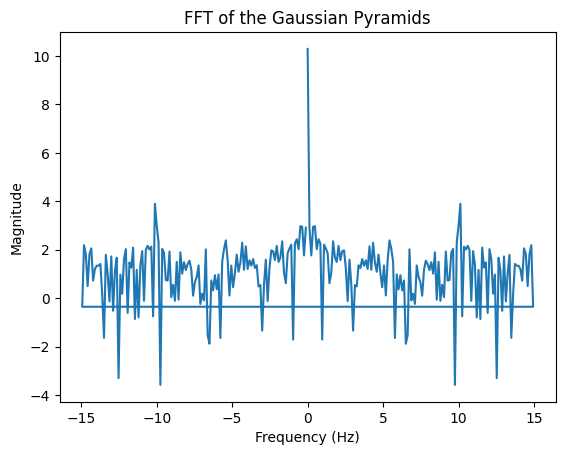

In [16]:
fft = np.fft.fft(gaussian_pyramids,axis=0)
frequencies = np.fft.fftfreq(gaussian_pyramids.shape[0], d=1.0/fps)
# Compute the magnitude of the frequency components
real_part = np.real(fft[:,:,0])
magnitude = np.abs(real_part)
# Take the logarithm of the magnitude to compress the dynamic range
log_magnitude = np.log(magnitude)


# Plot the logarithm of the magnitude
plt.plot(frequencies, log_magnitude[:, 0, 0])

# Add labels to the x- and y-axes
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

# Add a title to the plot
plt.title('FFT of the Gaussian Pyramids')


Text(0.5, 1.0, 'Peaks in the FFT of the Gaussian Pyramids')

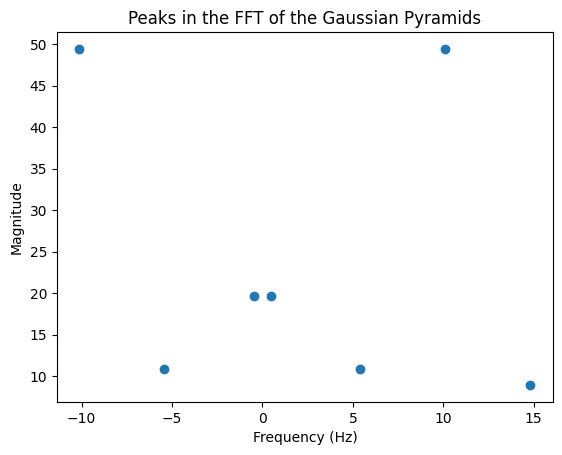

In [13]:
fft = np.fft.fft(gaussian_pyramids,axis=0)
frequencies = np.fft.fftfreq(gaussian_pyramids.shape[0], d=1.0/fps)
# Compute the magnitude of the frequency components
real_part = np.real(fft[:,:,0])
magnitude = np.abs(real_part)

# Use the "find_peaks" function to identify the peaks in the FFT
peaks, _ = find_peaks(magnitude[:, 0, 0], distance=30)
peak_frequencies = frequencies[peaks]
peak_magnitudes = magnitude[peaks]
# Plot the frequencies and magnitudes of the peaks
plt.scatter(peak_frequencies, peak_magnitudes[:, 0, 0])

# Add labels to the x- and y-axes
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

# Add a title to the plot
plt.title('Peaks in the FFT of the Gaussian Pyramids')

0.8433734939759036


Text(0.5, 1.0, 'FFT of the Filtered Gaussian Pyramids')

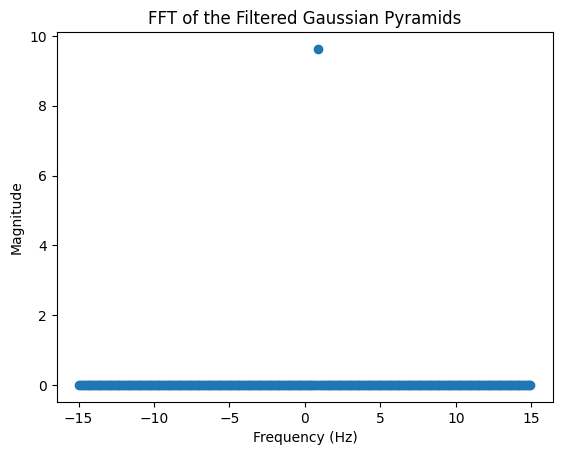

In [14]:
fft = np.fft.fft(gaussian_pyramids,axis=0)
frequencies = np.fft.fftfreq(gaussian_pyramids.shape[0], d=1.0/fps)
low = (np.abs(frequencies - freq_range[0])).argmin()
high = (np.abs(frequencies - freq_range[1])).argmin()

fft[:low] = 0
fft[high:] = 0
real_part = np.real(fft[:,:,0])
magnitude = np.abs(real_part)
peak_index = np.argmax(magnitude[:, 0, 0])
peak_frequency = frequencies[peak_index]
print(peak_frequency)
plt.scatter(frequencies, magnitude[:, 0, 0])

# Add labels to the x- and y-axes
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

# Add a title to the plot
plt.title('FFT of the Filtered Gaussian Pyramids')


In [15]:
filtered_pyramids = np.fft.ifft(fft, axis = 0).real
print(filtered_pyramids)

[[[[-0.03866151  0.00539929  0.00615814]
   [-0.0385981   0.00545791  0.00613291]
   [-0.03842021  0.00562716  0.00605701]
   ...
   [ 0.01647395  0.00074446 -0.02267848]
   [ 0.01646562  0.00073857 -0.02269464]
   [ 0.01646324  0.0007366  -0.02270004]]

  [[-0.03869932  0.00541793  0.00621097]
   [-0.03863476  0.00547676  0.00618567]
   [-0.03845511  0.00564659  0.00610962]
   ...
   [ 0.0164638   0.00068815 -0.02270651]
   [ 0.01645549  0.00068228 -0.02272266]
   [ 0.01645231  0.00068032 -0.02272803]]

  [[-0.03880205  0.00547666  0.00636737]
   [-0.03873624  0.00553603  0.00634192]
   [-0.03855176  0.00570754  0.00626539]
   ...
   [ 0.01642971  0.00052932 -0.02278265]
   [ 0.01642112  0.00052349 -0.02279878]
   [ 0.0164187   0.00052154 -0.02280416]]

  ...

  [[ 0.00430036 -0.01329814 -0.03321095]
   [ 0.00428    -0.01334873 -0.03314947]
   [ 0.00422067 -0.01349814 -0.0329736 ]
   ...
   [-0.0220744  -0.04766149  0.01513762]
   [-0.02208258 -0.04767775  0.01515426]
   [-0.02208557 